# Computational Social/Affective Neuroscience Preconference, SANS 2019
*Rob Chavez - May 2nd, 2019*



The code below was used to generate the analyses for my talk entitled *"Distributed Structural Connectivitiy Biomarkers of Personality"* at the [Computational Social Affective Neuroscience preconference](http://compsan.org/Preconference.html) at SANS 2019 in Miami. 

<img src="http://compsan.org/images/CSAN_Logo.svg" alt="drawing" width="100"/> 

In [1]:
%matplotlib inline
from nltools.data import Brain_Data

from nilearn import plotting, image, input_data, datasets
import numpy as np
import pandas as pd
import os
import nltools as nlt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from nltools.plotting import plot_brain

# Load data

Here we load the group 4D file which contains each subject's fractional anisotropy file registered to standard space. This space is then masked by areas which showed high SNR across subjects. Included in the behavioral data is a randomly generated training/testing label for splitting the data.

In [2]:
os.chdir("/Users/rober/Documents/neurodeb/shared/comp_sans/FA_data/")
behav = pd.read_csv('../scaled_rockland_wrangle_brainfiltered.csv')
behav['SubjectID'] = np.arange(1,325)

threshold is ignored for simple axial plots


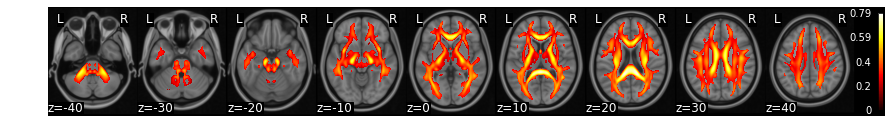

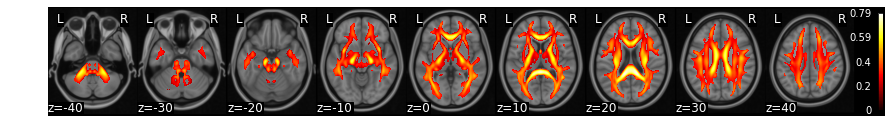

In [3]:
# Load FA data
fa_data = Brain_Data('compsans_FA.nii.gz', mask = 'snr_star_thr1.nii.gz', X = behav)

# plot masked mean FA
fa_data.mean().plot()

In [4]:
behav.head(5)

,ID,sex,age,neuroticism,extraversion,openness,agreeableness,conscientiousness,neuroticism_norm,extraversion_norm,...,attention_probs_tscore,rule_breaking_tscore,aggressive_tscore,internalizing_tscore,externalizing_tscore,totalscore_tscore,index0,niii_split,Holdout,SubjectID
0,A00008326,2,59,0.290358,0.184101,0.670866,-0.371185,0.347139,0.080975,0.085003,...,-0.571201,2.265439,1.374874,-0.340476,1.385534,0.317353,0,NKI0000.nii.gz,test,1
1,A00010893,1,28,-0.705090,0.962599,1.044572,1.214486,1.544597,-0.569405,1.107821,...,-0.655608,-0.748029,-0.604185,-0.679778,-1.016906,-0.404064,1,NKI0001.nii.gz,train,2
2,A00023510,1,23,0.290358,-0.447102,0.831161,-0.545480,-0.229646,0.577866,-0.305649,...,1.015673,1.239580,-0.451848,-0.146942,0.810005,0.537059,6,NKI0006.nii.gz,test,3
3,A00027443,1,15,-0.583736,0.180351,-0.568206,-1.027642,0.897520,-0.384595,0.330277,...,-0.811225,-0.748029,-0.604185,-0.405326,-0.367689,-0.501363,11,NKI0011.nii.gz,train,4
4,A00027544,1,22,-0.583736,0.180351,1.367128,-0.226882,1.026935,-0.384595,0.330277,...,0.900561,0.357382,-0.381862,1.332874,0.497933,1.152730,12,NKI0012.nii.gz,train,5


# Fit neuroticism model
Here we will fit the ridge regression model on the training data using a leave-one-out cross-validation and a alpha =.1. 

In [12]:
# split data one train/test
train = fa_data[fa_data.X['Holdout']=='train']
subject_id = train.X['SubjectID']
train.Y = train.X['neuroticism']

test = fa_data[fa_data.X['Holdout']=='test']
test.Y = test.X['neuroticism']

# fit model
stats_neuroticism= train.predict(algorithm='ridge',plot=False, 
                         cv_dict={'type': 'loso','subject_id':subject_id},
                         **{'alpha':.1})

# save weight map for use later
neuroticism_weightmap = stats_neuroticism['weight_map'].data

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.14
overall CV Correlation: -0.09


# Apply model to test sample
Here we will apply the model to the out-of-sample data, print a scatter plot and summary stats.

Holdout: R = 0.23257280541776504, p = 0.015428763803828682, R2 = 0.0540901098198896, RMSE =  0.9903652210688089
Plotting unthresholded image


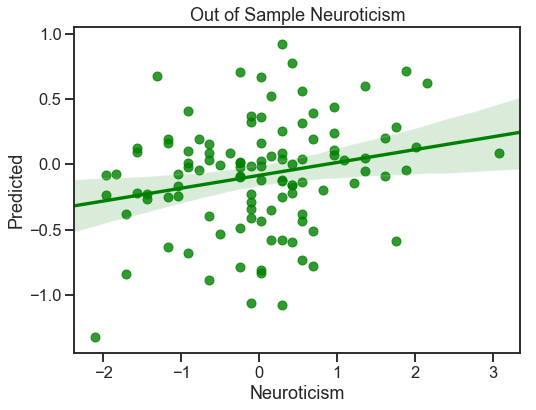

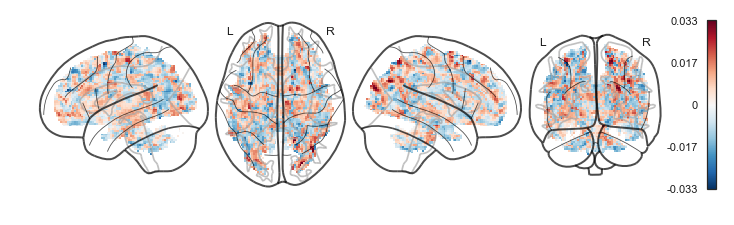

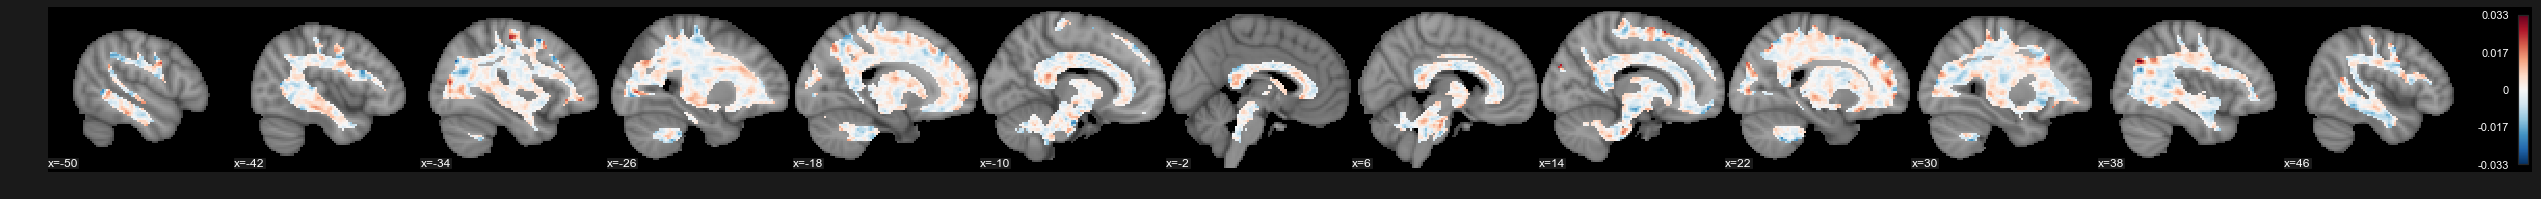

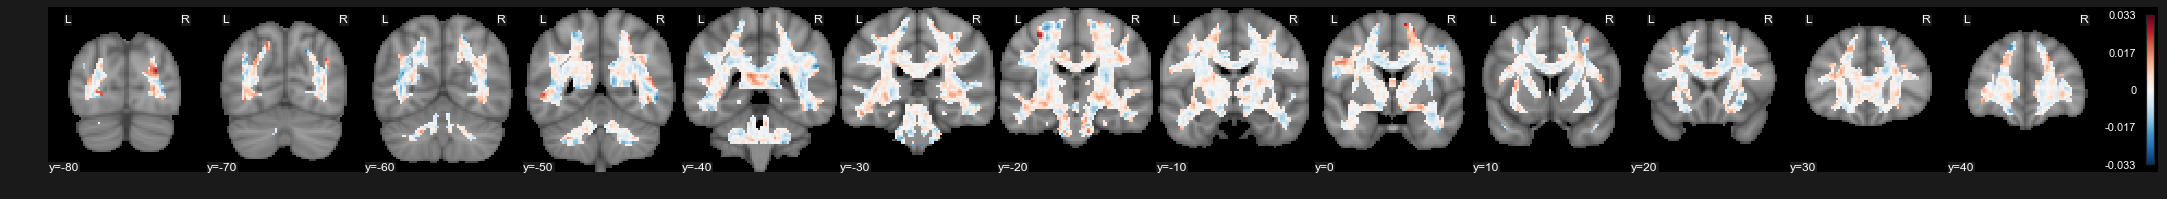

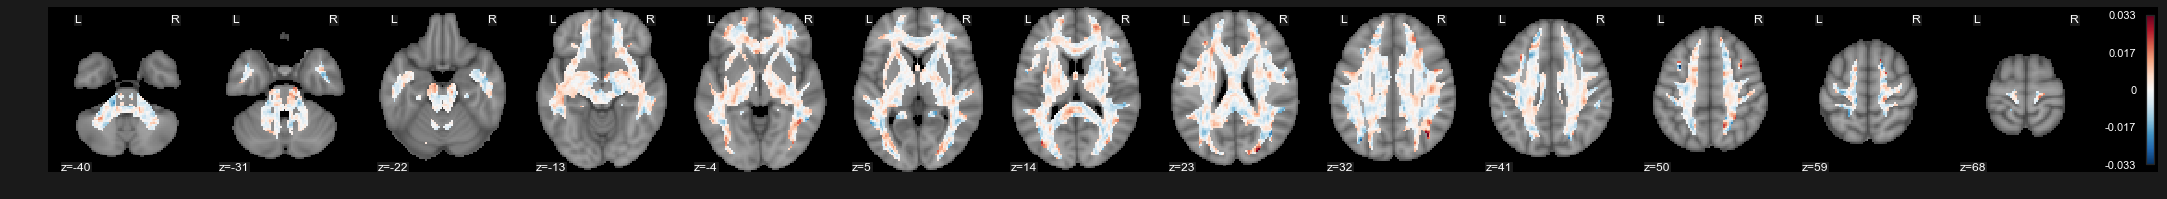

In [6]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_neuroticism,'neuroticism':test.X['neuroticism']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='neuroticism',y='Predicted', color='green').set_title("Out of Sample Neuroticism")
    plt.xlabel('Neuroticism')

# calculate fit metrics    
fit = pearsonr(data_neurotic.neuroticism, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.neuroticism, data_neurotic.Predicted))


print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

# plot brain
plot_brain(stats_neuroticism['weight_map'])

## Apply neuroticism model to psychopathology variables
Here we will use the weight map from the neuroticism analysis to test its predictive utility on interalizing and externaling behavior T-score data.

Holdout: R = 0.2750057334032946, p = 0.003971147072297118, R2 = 0.07562815340468394, RMSE =  0.9721705956067275


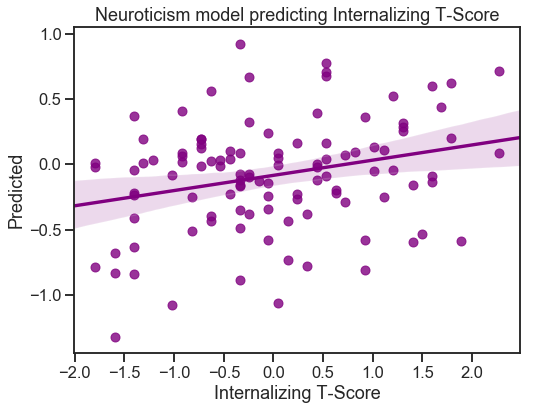

In [7]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_neuroticism,'internalizing_tscore':test.X['internalizing_tscore']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='internalizing_tscore',y='Predicted', color='purple').set_title("Neuroticism model predicting Internalizing T-Score")
    plt.xlabel('Internalizing T-Score')
        
# calculate fit metrics    
fit = pearsonr(data_neurotic.internalizing_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.internalizing_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))


Holdout: R = 0.12329959476400139, p = 0.2036169886846657, R2 = 0.015202790068966958, RMSE =  1.035749698610004


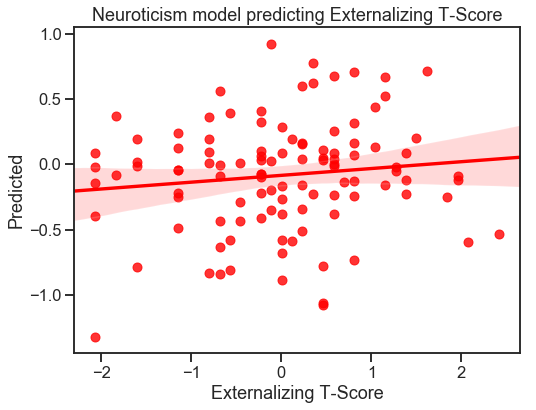

In [8]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['SubjectID'],'Predicted':predicted_neuroticism,'externalizing_tscore':test.X['externalizing_tscore']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='externalizing_tscore',y='Predicted', color='red').set_title("Neuroticism model predicting Externalizing T-Score")
    plt.xlabel('Externalizing T-Score')

# calculate fit metrics    
fit = pearsonr(data_neurotic.externalizing_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.externalizing_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))


# Compare to Univariate
It might be of interest to many how the multivariate prediction patters are related to standard univariate measures. To explort this, we ran a standard whole-brain univariate correlation using non-parametric permutations and TFCE for clustering in the holdout sample (N=108).

**We found no signficant clusters in which neuroticism was correlated with FA using standard univariate measures.**


In [9]:
tmap = Brain_Data('univar/neurot_tstat1.nii.gz', mask = 'snr_star_thr1.nii.gz')

Plotting voxels with stat value >= -5
Plotting voxels with stat value <= 5


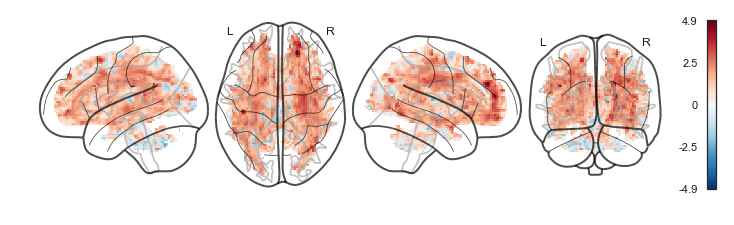

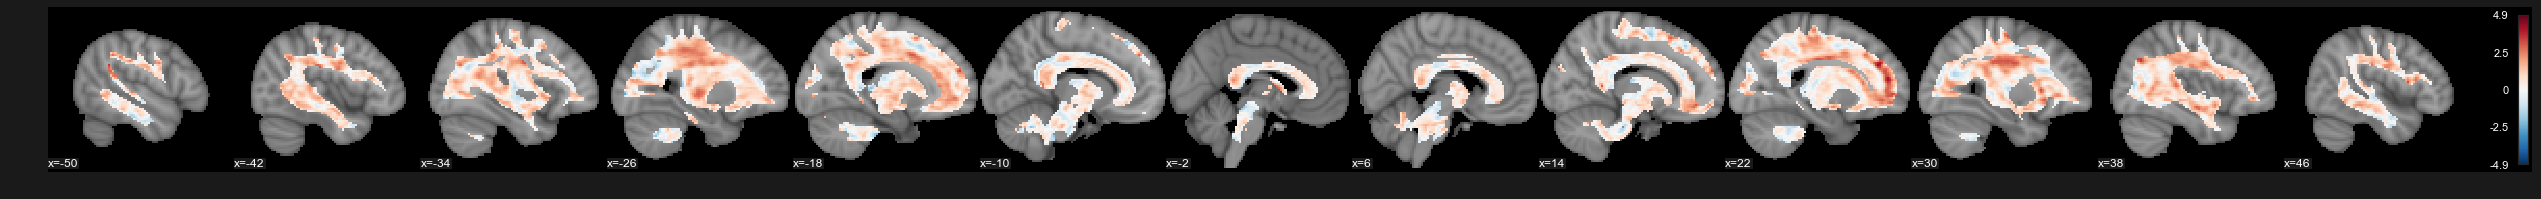

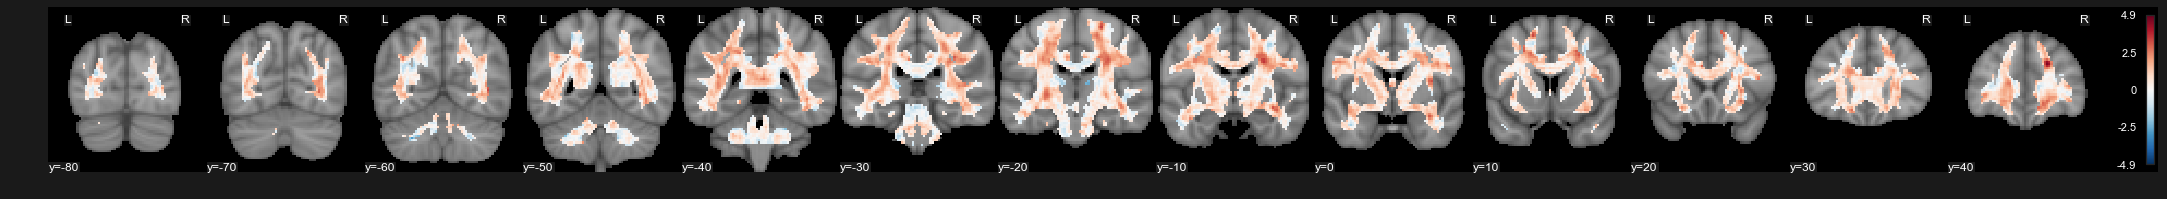

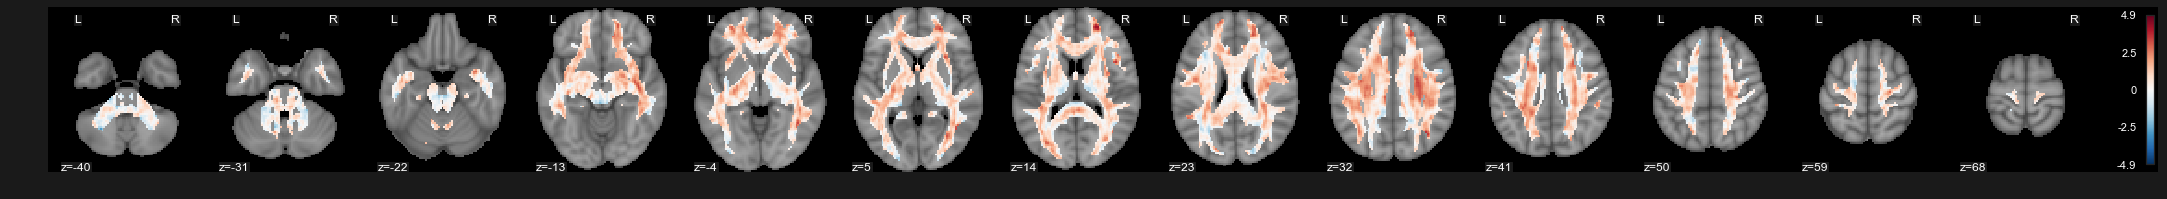

In [10]:
plot_brain(tmap, thr_upper= -5, thr_lower=5)

## Correlation between multivariate weight maps and univariate t-score maps
Printed below is the correlation between the multivariate weight map and the t-score map derived from the univariate analysis. As you can see, the model-derived weight map is not related to the t-score map generated from the univariate analysis. 

This suggests that a model derived from multivariate predictive model out performs standard univariate methods when relating white matter microstructure to neuroticism.

(0.040928564428048486, 1.6601122704459998e-21)

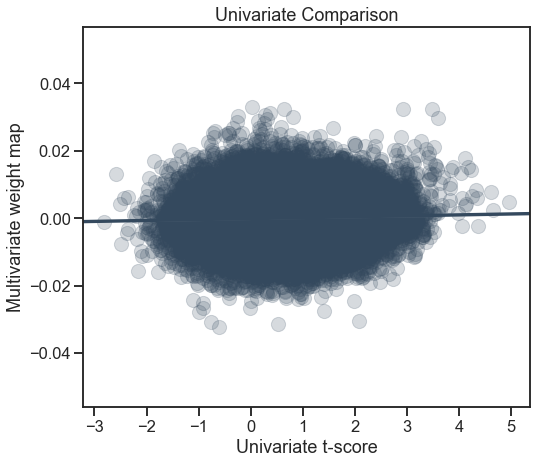

In [11]:
# plot
sns.set(rc={'figure.figsize':(8,7)})
sns.set_style("ticks")
wm_dat = pd.DataFrame(data={'univariate_tscore': tmap.data, 'multivariate_weight_map': neuroticism_weightmap})
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=wm_dat,x='univariate_tscore',
                y='multivariate_weight_map', 
                color= "#34495e",
                scatter_kws={'s':200, 'alpha':.2})
    plt.title('Univariate Comparison')
    plt.xlabel('Univariate t-score')
    plt.ylabel('Multivariate weight map')
    
    
# caluclate stats   
pearsonr(wm_dat.univariate_tscore, wm_dat.multivariate_weight_map)


In [71]:
# write to nifti for plotting
stats_neuroticism['weight_map'].write('neurticsim_weightmap.nii.gz')